In [1]:
import findspark
findspark.init()

import csv
import datetime
import numpy as np
from pyspark import SparkContext
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.tree import RandomForest, RandomForestModel
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#We need to clean the original data by reducing the number of columns first
def columnEliminator():
    with open("NYPD_Motor_Vehicle_Collisions.csv") as csv_file:
        rdr= csv.reader( csv_file, delimiter=',' )
        with open("NYPD_Motor_Vehicle_Collisions_clean.csv","wb") as f:
            wtr= csv.writer(f)
            for r in rdr:
                del r[6]
                wtr.writerow(r)
                
columnEliminator()

In [2]:
#Let's start Spark and read our csv file
sc = SparkContext(appName = "traffic")
lines = sc.textFile('NYPD_Motor_Vehicle_Collisions_clean.csv')

##There are supposed to be 28 columns, so let's filter the other rows
lines = lines.filter(lambda x: len(x.split(',')) == 28)
header = lines.first()
lines = lines.filter(lambda x: x != header)
print header
print lines.take(1)

DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
[u'10/21/2018,0:00,BROOKLYN,11214,40.59039,-73.99155,26 AVENUE                       ,CROPSEY AVENUE,,0,0,0,0,0,0,0,0,Unspecified,,,,,4004212,Station Wagon/Sport Utility Vehicle,,,,']


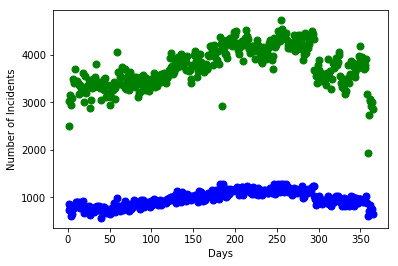

In [3]:
#Let's do some visualizations to understand the dependencies, first we'll group the number of total collisons
#and the number of collisons with injuries and deaths based on the day of the year
accidentPerDay = lines.map(lambda x: (x.split(',')[0][:-5],1))
injuredPerDay = lines.map(lambda x: (x.split(',')[0][:-5],int(x.split(',')[9]) + int(x.split(',')[10])))
totAccidentPerDay = accidentPerDay.reduceByKey(lambda x,y: x+y).collect()
totInjuredPerDay = injuredPerDay.reduceByKey(lambda x,y: x+y).collect()

dayAccident, accident = zip(*totAccidentPerDay)
dayAccident, accident = zip(*sorted(zip(dayAccident, accident)))
dayAccident, accident = list(dayAccident), list(accident)
dayAccident.pop(59)
accident[58] = int(accident[58]) + int(accident.pop(59))
dayAccident = [datetime.datetime.strptime(dayAccident[i],'%m/%d').timetuple().tm_yday for i in range(len(dayAccident))]

dayInjured, injured = zip(*totInjuredPerDay)
dayInjured, injured = zip(*sorted(zip(dayInjured, injured)))
dayInjured, injured = list(dayInjured), list(injured)
dayInjured.pop(59)
injured[58] = int(injured[58]) + int(injured.pop(59))
dayInjured = [datetime.datetime.strptime(dayInjured[i],'%m/%d').timetuple().tm_yday for i in range(len(dayInjured))]


plt.figure()
plt.plot(dayAccident, accident,'g.',markersize=14,linewidth=2)
plt.plot(dayInjured, injured,'b.',markersize=14,linewidth=2)

plt.ylabel('Number of Incidents')
plt.xlabel('Days')
plt.show()
#Here, green dots show the total number of collisions and blue dots are collisions with injuries or deaths as
#a function of the days over one year
#On January 1st, July 4th and December 25th, there are significantly fewer collisions than the other days

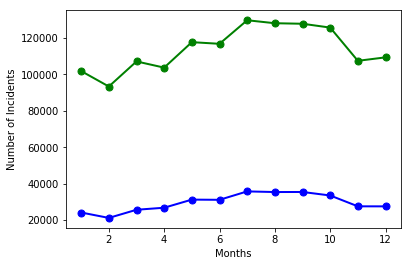

In [4]:
#This time let's look at the number of collisons vs the month of the year relationship
accidentPerMonth = lines.map(lambda x: (x.split(',')[0][:2],1))
injuredPerMonth = lines.map(lambda x: (x.split(',')[0][:2],int(x.split(',')[9])+int(x.split(',')[10])))
totAccidentPerMonth = accidentPerMonth.reduceByKey(lambda x,y: x+y).collect()
totInjuredPerMonth = injuredPerMonth.reduceByKey(lambda x,y: x+y).collect()

monthAccident, accident = zip(*totAccidentPerMonth)
monthAccident, accident = zip(*sorted(zip(monthAccident, accident)))
monthInjured, injured = zip(*totInjuredPerMonth)
monthInjured, injured = zip(*sorted(zip(monthInjured, injured)))

plt.figure()
plt.plot(monthAccident, accident,'g.-',markersize=14,linewidth=2)
plt.plot(monthInjured, injured,'b.-',markersize=14,linewidth=2)
plt.ylabel('Number of Incidents')
plt.xlabel('Months')
plt.show()

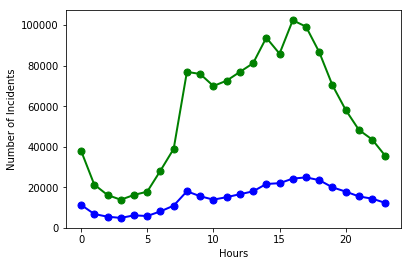

In [5]:
#Similarly, this plot shows the hour of the day vs the number of incidents
linesHour = lines.filter(lambda x: len(x.split(',')[1]) == 4 or len(x.split(',')[1]) == 5)
accidentPerHour = linesHour.map(lambda x: (int(x.split(',')[1][0]),1) if x.split(',')[1][1] == ':' else (x.split(',')[1][:2],1))
injuredPerHour = linesHour.map(lambda x: (int(x.split(',')[1][0]),int(x.split(',')[9])+int(x.split(',')[10])) if x.split(',')[1][1] == ':' else (x.split(',')[1][:2],int(x.split(',')[9])+int(x.split(',')[10])))
totAccidentPerHour = accidentPerHour.reduceByKey(lambda x,y: x+y).collect()
totInjuredPerHour = injuredPerHour.reduceByKey(lambda x,y: x+y).collect()

hourAccident, accident = zip(*totAccidentPerHour)
hourAccident, accident = zip(*sorted(zip(hourAccident, accident)))
hourInjured, injured = zip(*totInjuredPerHour)
hourInjured, injured = zip(*sorted(zip(hourInjured, injured)))


plt.figure()
plt.plot(hourAccident, accident,'g.-',markersize=14,linewidth=2)
plt.plot(hourInjured, injured,'b.-',markersize=14,linewidth=2)

plt.ylabel('Number of Incidents')
plt.xlabel('Hours')
plt.show()

In [6]:
#Pedestarians died the most over the last 6 years in NYC
motoristFatalities = lines.map(lambda x: int(x.split(',')[16]))
totmotoristFatalities = motoristFatalities.reduce(lambda x,y: x+y)

cyclistFatalities = lines.map(lambda x: int(x.split(',')[14]))
totcyclistFatalities = cyclistFatalities.reduce(lambda x,y: x+y)

pedFatalities = lines.map(lambda x: int(x.split(',')[12]))
totpedFatalities = pedFatalities.reduce(lambda x,y: x+y)

print 'Deaths involving a motorist:', totmotoristFatalities
print 'Deaths involving a cyclist:', totcyclistFatalities
print 'Deaths involving a pedestarian:', totpedFatalities

Deaths involving a motorist: 622
Deaths involving a cyclist: 110
Deaths involving a pedestarian: 869


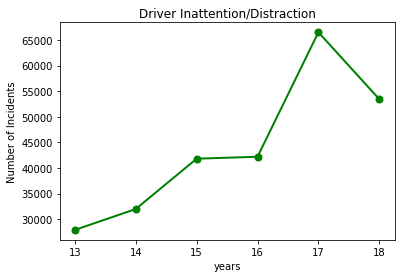

In [7]:
#Finally let's compare the reasons for these accidents and determine the top causes for collisions
def mapReducer(lines, colNum):
    mapper = lines.map(lambda x: ((x.split(',')[0][-2:],x.split(',')[colNum]),1))
    reducer = mapper.reduceByKey(lambda x,y: x+y).collect()
    return mapper, reducer

reasonv1, totReasonv1 = mapReducer(lines, 17)
reasonv2, totReasonv2 = mapReducer(lines, 18)
reasonv3, totReasonv3 = mapReducer(lines, 19)
reasonv4, totReasonv4 = mapReducer(lines, 20)
reasonv5, totReasonv5 = mapReducer(lines, 21)

reason = reasonv1.union(reasonv2)
reason = reason.union(reasonv3)
reason = reason.union(reasonv4)
reason = reason.union(reasonv5)
totReason = reason.reduceByKey(lambda x,y: x+y).collect()
sortedByFrequencyOfReason = sorted(totReason, key=lambda x: x[1],reverse=True)
reasonOfAccident, NumberOfAccidents = zip(*sortedByFrequencyOfReason[14:20])
years = [x[0] for x in reasonOfAccident]
years, NumberOfAccidents = zip(*sorted(zip(years, NumberOfAccidents)))

plt.figure()
plt.plot(years, NumberOfAccidents,'g.-',markersize=14,linewidth=2)

plt.ylabel('Number of Incidents')
plt.xlabel('years')
plt.title('Driver Inattention/Distraction')
plt.show()
#Probably, because of the increasing social media usage, distraction results in more and more accidents over the years
#Collision numbers increased more than 50% from 2016 to 2017
#ps. 2018 data is until October 25th

In [8]:
#Now let's cluster the locations of the accidents but before that we need to do more cleaning on the data
lines = lines.filter(lambda x: len(x.split(',')[4]) > 0 and len(x.split(',')[5]) > 0)
lines = lines.filter(lambda x: float(x.split(',')[4].encode('utf8')) > 35 and float(x.split(',')[4].encode('utf8')) < 45)
lines = lines.filter(lambda x: float(x.split(',')[5].encode('utf8')) > -80 and float(x.split(',')[5].encode('utf8')) < -70)
location = lines.map(lambda x: [float(x.split(',')[4].encode('utf8')),float(x.split(',')[5].encode('utf8'))])

# After cleaning the data, we need to try a few number of centroids and look at the error associated with
#each of these number of centroids
#When the change in error is less than 5%(you can set this to another value), we can start our algorithm 
#with that many number of centroids
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return  (sum([x**2 for x in (np.asarray(point) - np.asarray(center))]))**0.5

error_list=[]
k = [5, 10, 15, 20, 25, 30, 35]
for i in k:
    clusters = KMeans.train(location, i, maxIterations=20,runs=20, initializationMode="random")
    WSSSE = location.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    error_list.append(WSSSE)

for i in range(7):
    print 'k=', k[i], "and error=", error_list[i]

/usr/local/opt/apache-spark/libexec/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


k= 5 and error= 51828.4288078
k= 10 and error= 36092.4193075
k= 15 and error= 29407.6430638
k= 20 and error= 24864.0725821
k= 25 and error= 23112.3923705
k= 30 and error= 20080.9845455
k= 35 and error= 18339.2278079


In [9]:
#Let's choose the optimal k as 20
k_optimal = 20
clusters = KMeans.train(location, k_optimal, maxIterations=30,runs=30, initializationMode="random")

centersOfAccidents = []
for i in range(0,k_optimal):
    centeroid = clusters.centers[i]
    centersOfAccidents.append(centeroid)
print centersOfAccidents

[array([ 40.6611639 , -73.90287249]), array([ 40.86782422, -73.90000949]), array([ 40.83318467, -73.9300852 ]), array([ 40.75786977, -73.9801093 ]), array([ 40.88039083, -73.85207133]), array([ 40.65482501, -73.76311801]), array([ 40.73878742, -73.87105635]), array([ 40.66992744, -73.97475151]), array([ 40.83650548, -73.84475126]), array([ 40.76143152, -73.81729325]), array([ 40.82723775, -73.89120192]), array([ 40.70168219, -73.94011529]), array([ 40.58384377, -74.14372677]), array([ 40.69384303, -73.82129876]), array([ 40.62655469, -74.02704398]), array([ 40.60766283, -73.95933632]), array([ 40.75150507, -73.92008318]), array([ 40.73275426, -73.74964006]), array([ 40.72131621, -73.9965074 ]), array([ 40.79596896, -73.94888742])]


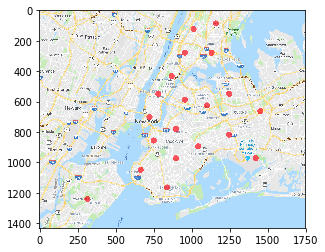

In [10]:
#We found all the centroids, I plotted them in google maps and here is how they look like
img=mpimg.imread('./accident_clusters.png')
imgplot = plt.imshow(img)
plt.show()

In [11]:
#After doing sufficient visulaizations, we can determine our features to help us estimate the accidents
#The features we're going to use are:
#day in the year, time in the day, zip code, longitude, latitude, temperature, precipitation
lines = lines.filter(lambda x: len(x.split(',')[4]) > 0 and len(x.split(',')[5]) > 0)
lines = lines.filter(lambda x: float(x.split(',')[4].encode('utf8')) > 35 and float(x.split(',')[4].encode('utf8')) < 45)
lines = lines.filter(lambda x: float(x.split(',')[5].encode('utf8')) > -80 and float(x.split(',')[5].encode('utf8')) < -70)
lines = lines.filter(lambda x: len(x.split(',')[3]) == 5)

def prepareAccidentData(x):
    date = x.split(',')[0]
    
    if x.split(',')[0][0:5] == '02/29':
        day = datetime.datetime.strptime('02/28','%m/%d').timetuple().tm_yday
    else:
        day = datetime.datetime.strptime(x.split(',')[0][0:5],'%m/%d').timetuple().tm_yday
    
    if len(x.split(',')[1]) == 5:
        time = int(x.split(',')[1][0:2])
    else:
        time = int(x.split(',')[1][0])
        
    try: 
        zipCode = int(x.split(',')[3])
    except ValueError: 
        zipCode = 10000

    latitude = float(x.split(',')[4])
    longitude = float(x.split(',')[5])
    latlng = float(x.split(',')[4])*float(x.split(',')[5])
    injury = int(x.split(',')[9])
    
    return (date,(injury,day,time,zipCode,longitude,latitude,latlng))

#I scraped average temperature and precipitation data for NYC from https://www.wunderground.com
linesAcc = lines.map(prepareAccidentData)
linesW = sc.textFile('weather.csv')
headerW = linesW.first()
linesW = linesW.filter(lambda x: x != headerW)
linesW = linesW.map(lambda x: (x.split(',')[0],(int(x.split(',')[1]),float(x.split(',')[2]))))
print headerW
print linesW.take(1)

Date,AverageTemperature,Average Precipitation
[(u'01/01/2013', (34, 0.0))]


In [12]:
#We need to create labeled points to feed into our trainers
lines = linesW.join(linesAcc)

def parseData(line):
    temp = line[1][0][0]
    precipitation = line[1][0][1]
    
    if line[1][1][0] > 0:
        label = 1
    else:
        label = 0
    
    day = line[1][1][1]
    time = line[1][1][2]
    zipCode = line[1][1][3]
    lng = line[1][1][4]
    lat = line[1][1][5]
    lnglat= line[1][1][6]
    
    features = [day,time,zipCode,lng,lat,lnglat,temp,precipitation]

    return LabeledPoint(label, features)

parsedData = lines.map(parseData)
print parsedData.take(1)

[LabeledPoint(0.0, [267.0,0.0,10014.0,-74.00882,40.74238,-3015.29546779,79.0,0.0])]


In [13]:
training , crossV, test = parsedData.randomSplit([0.7,0.2,0.1], seed = 11L)

modelRF = RandomForest.trainClassifier(training, numClasses=2, categoricalFeaturesInfo={}, 
                                     numTrees=5, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=10, maxBins=32)
predictions = modelRF.predict(test.map(lambda x: x.features))
labelsAndPredictions = test.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(test.count())
print("Test Error with Random Forest Classifier= " + str(testErr))

Test Error with Random Forest Classifier= 0.18629271665


In [14]:
modelLR = LogisticRegressionWithLBFGS.train(test)
labelsAndPreds = test.map(lambda p: (p.label, modelLR.predict(p.features)))
testErr = labelsAndPreds.filter(lambda lp: lp[0] != lp[1]).count() / float(test.count())
print("Test Error with Logistic Regression= " + str(testErr))

sc.stop()

Test Error with Logistic Regression= 0.186279161188
